### Importing required libraries

In [2]:
%matplotlib inline

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats
from sklearn import cross_validation
from sklearn import linear_model



### Utilities

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [2]:
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

In [3]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)

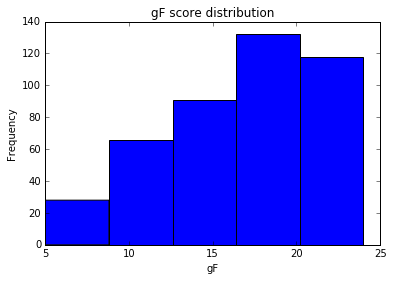

5

In [6]:
# gF score distribution 
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(1,50,1)) 

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits)

### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

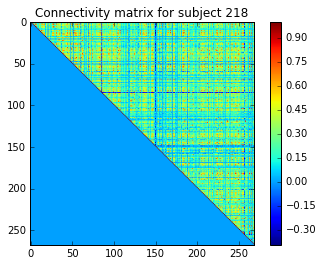

In [5]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]
    

### Test
Reproducing the work of [Finn et al](http://www.nature.com/neuro/journal/v18/n11/full/nn.4135.html), in a Leave-one-out cross validation (LOOCV) loop, only the edges with a significant correlation with the gF score (on training data) are selected and a statistic (network strengh) is computed on them; then  a first-degree polynomial is fit to model the relation between the statistic and the behavioural variable and it's used to predict the score on the test subject.
Two separate models are built for negatively and positively correlated edges.

In [129]:
# for each edge returns rho and p-value
pears = [stats.pearsonr(edges[:,i],gF) for i in range(0,n_edges)]
#pears = np.apply_along_axis(lambda row: stats.pearsonr(row,gF),0,edges)


In [6]:
# Leave-One-Out Cross validation

loo = cross_validation.LeaveOneOut(n_subj)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])

def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[test_index,idx_filtered_pos].sum()
        if(len(idx_filtered_neg)>0):
            str_neg_test = edges[test_index,idx_filtered_neg].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[i] = lr_pos.predict(str_pos_test)
        errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
        
        if(filtered_neg.shape[1]>0):
            lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
            predictions_neg[i] = lr_neg.predict(str_neg_test) 
            errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
        else:
            errors_neg[i] = np.nan
            predictions_neg[i] = np.nan
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)
p=0.01
regress(p,gF,edges)

preds_1 = predictions_pos
preds_2 = predictions_neg

In [41]:
# 5-fold cross validation

k = 5
cv = cross_validation.StratifiedKFold(bins,k)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj])
errors_neg = np.zeros([n_subj])
predictions_pos = np.zeros([n_subj])
predictions_neg = np.zeros([n_subj])

def regress(p,score,edges):
    f = FloatProgress(min=0, max=k)
    display(f)
    for train_index, test_index in cv:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[np.ix_(test_index,idx_filtered_pos)].sum()
        if(len(idx_filtered_neg)>0):
            str_neg_test = edges[np.ix_(test_index,idx_filtered_neg)].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[test_index] = lr_pos.predict(str_pos_test)
        errors_pos[test_index] = abs(predictions_pos[test_index]-gF[test_index])
        if(filtered_neg.shape[1]>0):
            lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
            predictions_neg[test_index] = lr_neg.predict(str_neg_test) 
            errors_neg[test_index] = abs(predictions_neg[test_index]-gF[test_index])
        else:
            errors_neg[test_index] = np.nan
            predictions_neg[test_index] = np.nan
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)
p=0.01
regress(p,gF,edges)

preds_3 = predictions_pos
preds_4 = predictions_neg

In [13]:
# 10-fold cross validation

k = 10
cv = cross_validation.StratifiedKFold(bins,k)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj])
errors_neg = np.zeros([n_subj])
predictions_pos = np.zeros([n_subj])
predictions_neg = np.zeros([n_subj])

def regress(p,score,edges):
    f = FloatProgress(min=0, max=k)
    display(f)
    for train_index, test_index in cv:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[np.ix_(test_index,idx_filtered_pos)].sum()
        if(len(idx_filtered_neg)>0):
            str_neg_test = edges[np.ix_(test_index,idx_filtered_neg)].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[test_index] = lr_pos.predict(str_pos_test)
        errors_pos[test_index] = abs(predictions_pos[test_index]-gF[test_index])
        
        if(filtered_neg.shape[1]>0):
            lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
            predictions_neg[test_index] = lr_neg.predict(str_neg_test) 
            errors_neg[test_index] = abs(predictions_neg[test_index]-gF[test_index])
        else:
            errors_neg[test_index] = np.nan
            predictions_neg[test_index] = np.nan
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)
p=0.01
regress(p,gF,edges)

preds_5 = predictions_pos
preds_6 = predictions_neg

### Results

In [11]:
results = {'finn_ext_preds_pos':predictions_pos, 'finn_ext_preds_neg':predictions_neg, 'finn_ext_errors_pos':errors_pos, 
           'finn_ext_errors_neg':errors_neg,'finn_ext_score':gF }
sio.savemat('res_finn_ext.mat',results)

In [14]:
results = {'finn_ext_preds_pos':preds_1, 'finn_ext_preds_neg':preds_2, 'finn_ext_preds_pos_5FCV':preds_3, 
           'finn_ext_preds_neg_5FCV':preds_4,'finn_ext_preds_pos_10FCV':preds_5, 'finn_ext_preds_neg_10FCV':preds_6,
           'finn_ext_score':gF}
sio.savemat('res_finn_ext_CV.mat',results)

In [12]:
print('Mean error positive model:',np.mean(errors_pos))
print('Mean error negative model:',np.mean(errors_neg))

print(predictions_pos.transpose())
print(predictions_neg.transpose())
print(gF)

Mean error positive model: 3.95301480424
Mean error negative model: nan
[[ 15.85809627  15.95586187  16.34968578  16.61880382  16.23745061
   19.63366932  17.21719725  17.13669761  15.16134973  15.87619617
   15.5648202   17.36461118  16.87304253  15.50225299  15.63368843
   17.18734401  19.50240572  16.36832833  16.33552894  20.76008362
   18.65492084  17.71280478  17.06243587  19.44386555  16.82441074
   14.96813973  17.63156595  20.74921938  15.55088587  16.4801919
   17.54151325  16.42402964  15.66427891  16.39000978  15.85969824
   15.78336071  18.0872606   15.39365139  16.38139101  16.80780147
   16.99445076  16.88093986  15.77689168  14.96124768  15.32183325
   16.05425471  16.72787074  16.54505512  19.3795545   16.52304165
   16.1117452   15.60643035  15.86211087  16.23175149  16.23526579
   17.65679594  16.97750592  15.75583158  16.70792501  14.67761167
   15.47843106  16.82805994  17.75829345  16.36716522  15.98079059
   16.44319205  15.68442048  14.61715821  17.54240292  15.

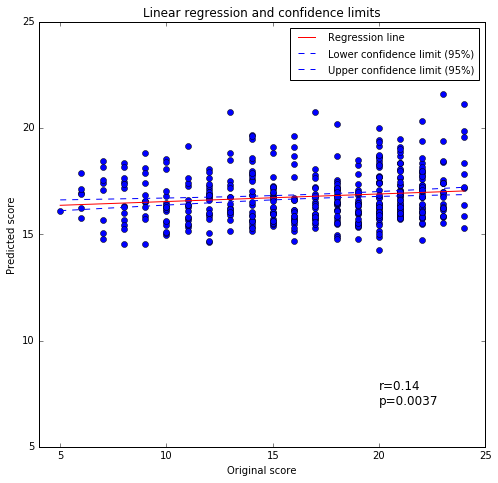

In [13]:
regression_plot(np.ravel(gF),np.ravel(predictions_pos),n_subj,'Linear regression and confidence limits') 

Finn et al. obtained *r* = 0.5